In [1]:
from matplotlib import pyplot as plt
import numpy as np
import outset as otst
from outset import patched as otst_patched
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from pylib.analyze_epistasis import (
    assay_epistasis_naive,
    describe_skeletons,
    skeletonize_naive,
)
from pylib.auxlib._jitter import jitter
from pylib.modelsys_explicit import GenomeExplicit
from pylib.modelsys_explicit import (
    GenomeExplicit,
    CalcKnockoutEffectsAdditive,
    CalcKnockoutEffectsEpistasis,
    create_additive_array,
    create_epistasis_matrix_disjoint,
    describe_additive_array,
    describe_epistasis_matrix,
)


In [2]:
np.random.seed(1234)


## Create Sample Genome


In [3]:
num_sites = 4000
distn = lambda x: np.random.rand(x) * 0.7  # mean effect size of 0.7 / 2
additive_array = create_additive_array(num_sites, 0.05, distn)  # 50 sites
epistasis_matrix = create_epistasis_matrix_disjoint(num_sites, 20, 8)
genome = GenomeExplicit(
    [
        CalcKnockoutEffectsAdditive(additive_array),
        CalcKnockoutEffectsEpistasis(epistasis_matrix, effect_size=(0.7, 1.6)),
    ],
)


## Describe and Inspect Genome


In [4]:
dfa = describe_additive_array(additive_array)
dfb = describe_epistasis_matrix(epistasis_matrix)
df_genome = pd.DataFrame.merge(dfa, dfb, on="site")
df_genome["site type"] = (
    df_genome["additive site"].astype(int)
    + df_genome["epistasis site"].astype(int) * 2
).map(
    {
        0: "neutral",
        1: "additive",
        2: "epistasis",
        3: "both",
    }
)

df_genome


,site,additive site,additive effect,epistasis site,num epistasis effects,site type
0,0,False,0.000000,False,0,neutral
1,1,False,0.000000,False,0,neutral
2,2,False,0.000000,False,0,neutral
3,3,False,0.000000,False,0,neutral
4,4,False,0.000000,False,0,neutral
...,...,...,...,...,...,...
3995,3995,True,0.059342,False,0,additive
3996,3996,False,0.000000,False,0,neutral
3997,3997,False,0.000000,False,0,neutral
3998,3998,False,0.000000,False,0,neutral


How many of each kind of site are in the genome?


neutral      3652
additive      188
epistasis     148
both           12
Name: site type, dtype: int64
non-neutral 348


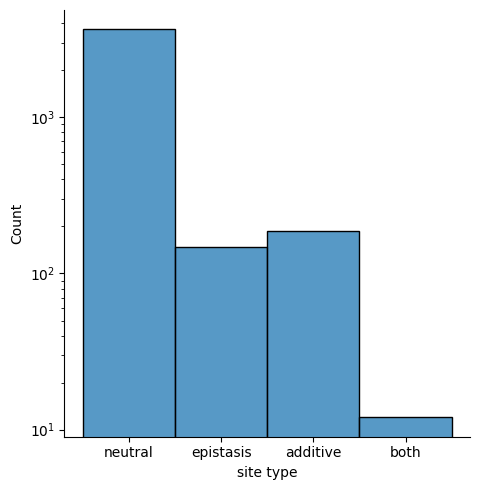

In [5]:
sns.displot(df_genome["site type"])
plt.yscale("log")
print(df_genome["site type"].value_counts())
print("non-neutral", (df_genome["site type"] != "neutral").sum())


## Perform Skeletonizations


In [6]:
num_skeletonizations = 20
skeletons = np.vstack(
    [
        skeletonize_naive(num_sites, genome.test_knockout)
        for _ in tqdm(range(num_skeletonizations))
    ],
)


100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


Example skeleton.


array([False, False, False, ..., False, False, False])

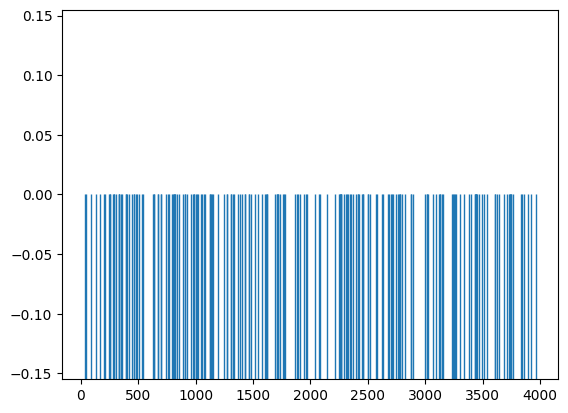

In [7]:
# convert from knockout true to retained true
retained_sites = ~skeletons[0].astype(bool)
sns.rugplot(
    np.flatnonzero(retained_sites),
    height=0.5,
)
retained_sites


## Describe Skeletons


Without neutral sites.


<AxesSubplot: xlabel='skeleton order', ylabel='skeleton frequency'>

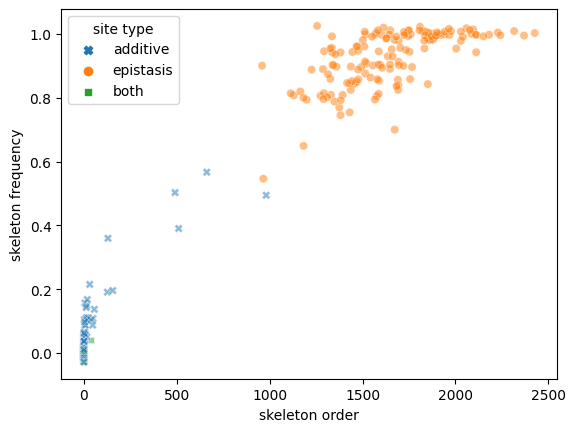

In [8]:
otst_patched.scatterplot(
    pd.DataFrame(
        {
            "skeleton order": np.mean(skeletons, axis=0),
            "skeleton frequency": jitter(
                np.mean(skeletons.astype(bool), axis=0),
                amount=0.01,
            ),
            "site type": df_genome["site type"],
        },
    ),
    x="skeleton order",
    y="skeleton frequency",
    hue="site type",
    style="site type",
    hue_order=["additive", "epistasis", "both"],
    alpha=0.5,
)


Including neutral sites.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


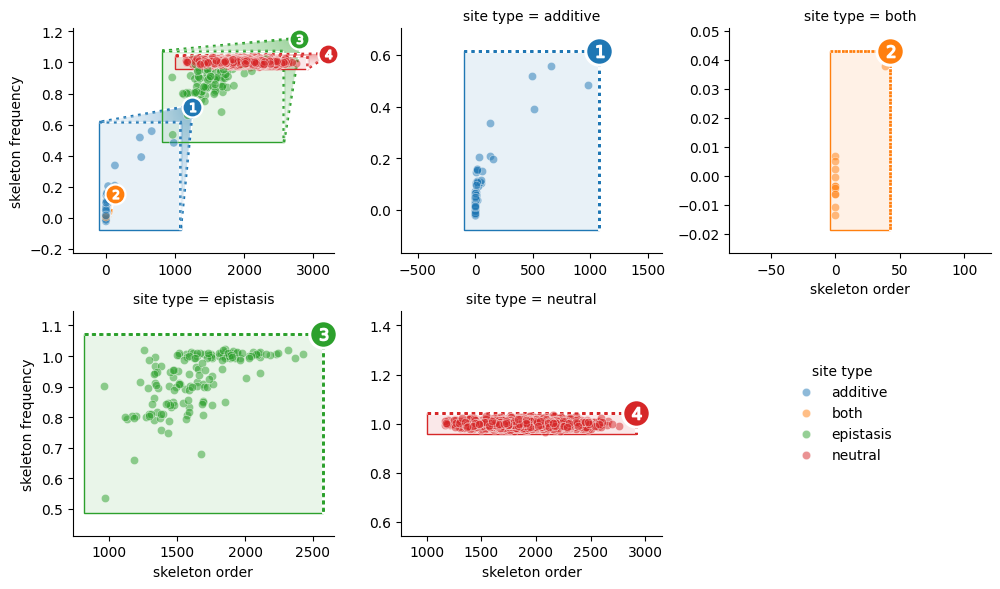

,site,"skeleton dose, excluded","skeleton dose std, excluded","skeleton dose ptp, excluded","skeleton exclusion order, excluded","skeleton exclusion order std, excluded","skeleton exclusion order ptp, excluded","skeleton outcome count, excluded","skeleton outcome frequency, excluded","skeleton dose, included",...,"skeleton outcome frequency, included",jackknife dose,jackknife dose std,jackknife dose ptp,raw jackknife result,raw jackknife result std,raw jackknife result ptp,jackknife result,jackknife result std,jackknife result ptp
0,0,3795.7,1.866604,8.0,2104.10,1070.034426,3495.0,20,1.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,3795.7,1.866604,8.0,1926.30,1062.949774,3664.0,20,1.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,3795.7,1.866604,8.0,2293.95,1040.836125,3332.0,20,1.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3795.7,1.866604,8.0,1501.45,1279.991714,3727.0,20,1.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,3795.7,1.866604,8.0,1806.60,1177.297637,3542.0,20,1.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3832,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,3795.7,...,1.0,3796.7,1.866604,8.0,1.691584,0.002178,0.008923,1.691584,0.002178,0.008923
3996,3843,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,3795.7,...,1.0,3796.7,1.866604,8.0,1.692624,0.002178,0.008923,1.692624,0.002178,0.008923
3997,3857,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,3795.7,...,1.0,3796.7,1.866604,8.0,1.196803,0.002178,0.008923,1.196803,0.002178,0.008923
3998,3918,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,3795.7,...,1.0,3796.7,1.866604,8.0,1.420161,0.002178,0.008923,1.420161,0.002178,0.008923


In [9]:
assert (np.diff(df_genome["site"]) == 1).all()  # is sorted?
og = otst.OutsetGrid(
    data=pd.DataFrame(
        {
            "skeleton order": np.mean(skeletons, axis=0),
            "skeleton frequency": jitter(
                np.mean(skeletons.astype(bool), axis=0),
                amount=0.01,
            ),
            "site type": df_genome["site type"],
        },
    ),
    x="skeleton order",
    y="skeleton frequency",
    hue="site type",
    col="site type",
    col_wrap=3,
)
og.map_dataframe(
    sns.scatterplot,
    x="skeleton order",
    y="skeleton frequency",
    alpha=0.5,
    legend=False,
)
og.add_legend(loc="lower right", bbox_to_anchor=(0.9, 0.2))
og.marqueeplot()

plt.show()

df_skeletons = describe_skeletons(skeletons, genome.test_knockout)

df_skeletons


How many unique sites are in any skeleton?


In [10]:
np.any(
    (~skeletons.astype(bool)),
    axis=0,
).sum()


283

## Use Skeleton Jackknifes to Differentiate Epistasis & Small-effect Sites


In [11]:
est = assay_epistasis_naive(
    df_skeletons,
    exclusion_frequency_thresh=0.3,
    jackknife_severity_thresh=0.2,
)
est


{'num epistasis sites estimate': 39,
 'exclusion frequency cutoff': 0.3,
 'jackknife severity cutoff': 1.1855856927099644}

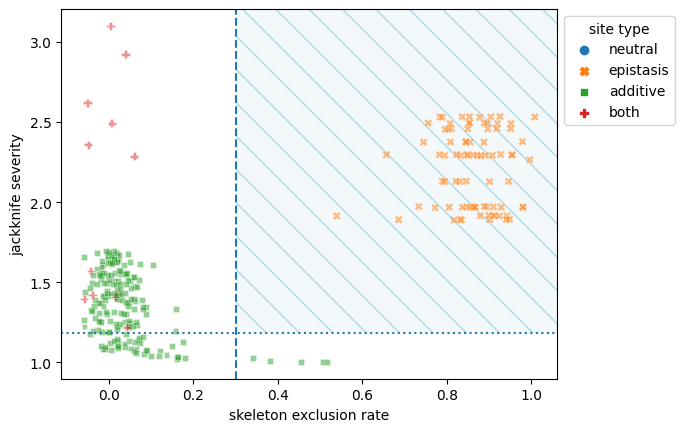

In [12]:
df_joint = pd.DataFrame.merge(
    df_genome,
    df_skeletons,
    on="site",
)
ax = sns.scatterplot(
    data={
        "skeleton exclusion rate": jitter(
            df_joint["skeleton outcome frequency, excluded"],
            amount=0.03,
        ),
        "jackknife severity": df_joint["jackknife result"],
        "site type": df_joint["site type"],
    },
    x="skeleton exclusion rate",
    y="jackknife severity",
    hue="site type",
    style="site type",
    alpha=0.5,
)
sns.move_legend(
    ax,
    "upper left",
    bbox_to_anchor=(1, 1),
)
plt.axvline(
    est["exclusion frequency cutoff"],
    ls="--",
)
plt.axhline(
    est["jackknife severity cutoff"],
    ls=":",
)
with plt.rc_context({"hatch.color": "lightblue"}):
    plt.gca().add_patch(
        plt.Rectangle(
            (
                est["exclusion frequency cutoff"],
                est["jackknife severity cutoff"],
            ),
            plt.xlim()[1] - est["exclusion frequency cutoff"],
            plt.ylim()[1] - est["jackknife severity cutoff"],
            alpha=0.05,
            fill=True,
            hatch="\\",
            zorder=-1,
        )
    )
